# Торговый бот 



разработать алгоритм торгового робота, который автоматически совершает сделки на основе скользящих средних и стоп-лосса,
анализируя исторические данные акций.

Обязательно использовать реальные дневные данные стоимости акций с бирж, например московской биржи.


буду использовать библиотеку apimoex: https://wlm1ke.github.io/apimoex/build/html/api.html#id1

In [ ]:
!pip install apimoex
from datetime import timedelta, datetime

import apimoex
import requests
import pandas as pd

import matplotlib.pyplot as plt


!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
url = f'https://iss.moex.com/iss/history/engines/stock/markets/shares/securities.json?date=2004-03-24'

response = requests.get(url)
data = response.json()

columns = data['history']['columns']
rows = data['history']['data']

df = pd.DataFrame(rows, columns=columns)

df.head(2)

## Исходные данные:
- Формат данных: `Pandas DataFrame`.  
- Индекс: дата/время (тип `datetime`).  
- Колонки (обязательный порядок):  
  `Open`, `High`, `Low`, `Close`.  
- Источник данных: реальные дневные котировки с **NYSE** или **Московской биржи**.  


In [327]:
ticker = 'AFLT'

In [305]:
#with requests.Session() as session:
#    data = apimoex.get_board_history(
#        session,
#        ticker,
#        start=start,   
#        end = finish,    
#        columns=('OPEN', 'CLOSE', 'HIGH', 'LOW', 'TRADEDATE')  
#    )
#df = pd.DataFrame(data)
#
#df.set_index('TRADEDATE', inplace = True)

In [306]:
#df['MA30'] = df['CLOSE'].rolling(30).mean()
#df['MA90'] = df['CLOSE'].rolling(90).mean()

In [307]:
#df['CLOSE'].rolling(30).mean().plot() 

In [308]:
#fig = make_subplots(subplot_titles=('пробный график цены акции ',))
#fig.add_trace(
    #go.Candlestick(
        #x = df.index,
        #open = df['OPEN'],
        #high = df['HIGH'],
        #low = df['LOW'],
        #close = df['CLOSE']
    #)
#)
#fig.show()   

## Обязательные переменные:
1. **`money`** – стартовый капитал (1 000 000 денежных единиц).  
2. **`start`** – дата начала периода в формате `YYYY-MM-DD` (2015-01-01).  
3. **`finish`** – дата окончания периода в формате `YYYY-MM-DD` (2020-12-31).  
4. **`stop_loss`** – уровень стоп-лосса (5% от цены покупки).  
5. **`short_window`** – размер короткого скользящего окна (30 торговых дней).  
6. **`long_window`** – размер длинного скользящего окна (90 торговых дней).  


In [328]:
money = 100000
start = '2015-01-01'
finish = '2020-12-31'
stop_loss = 0.05
short_window = 30 
long_window = 90 

## Требования к отчету:
Отчет (`DataFrame`) должен содержать следующие колонки:  
| Колонка         | Описание                                                                 |
|-----------------|-------------------------------------------------------------------------|
| **date**        | Дата события (формат `YYYY-MM-DD`).                                    |
| **signal**      | Тип сигнала: `sig_buy`, `buy`, `sig_sale`, `sale`, `stop-loss`.        |
| **num_shares**  | Количество акций на балансе (целое число, ≥ 0).                        |
| **share_price** | Цена акции на момент действия сигнала (в день сделки).                 |
| **share_value** | Текущая стоимость портфеля (`num_shares × share_price`).              |
| **cash**        | Наличные на счете (округление до **2 знаков** после запятой!).         |

**Пример полного отчета:**  
| date       | signal      | num_shares | share_price | share_value  | cash          |
|------------|-------------|------------|-------------|--------------|---------------|
| 2020-01-01 | sig_buy     | 0          | 100.00      | 0.00         | 1,000,000.00  |
| 2020-01-02 | buy         | 10101      | 99.00       | 999,999.00   | 1.00          |
| 2020-02-22 | sig_sale    | 10101      | 125.00      | 1,262,625.00 | 1.00          |
| 2020-02-23 | sale        | 10101      | 125.62      | 0.00         | 1,268,888.62  |
| 2020-03-11 | sig_buy     | 0          | 125.45      | 0.00         | 1,268,888.62  |
| 2020-03-12 | buy         | 10044      | 126.33      | 1,268,858.52 | 30.10         |
| 2020-03-18 | stop-loss   | 10044      | 120.01      | 1 205 380.44 | 1,205,410.54  |
| 2020-05-01 | sig_buy     | 0          | 70.00       | 0.00         | 1,205,410.54  |

**Итоговые расчеты:**  
- Вывести **итоговую стоимость портфеля** на момент последней сделки (`sale` или `stop-loss`).  
- Рассчитать **процент прироста/убытка** от начального капитала по формуле:  
  ```
  Процент = ((Итоговая стоимость - 1,000,000) / 1,000,000) × 100%

In [335]:
def trade_bot_moex(tiker, money, start, finish, stop_loss,  short_window,  long_window     ):
    
    quantity = 0
    signal = None
    report = list()
    prew_price = None
    number = 0
    signal = None
    answer = list()
    
    # скачиваем данные с московсой биржи 
    with requests.Session() as session:
        data = apimoex.get_board_history(
            session,
            tiker,
            start=start,   
            end = finish,    
            columns=('OPEN', 'CLOSE', 'HIGH', 'LOW', 'TRADEDATE')  
        )
    df = pd.DataFrame(data)
    df.set_index('TRADEDATE', inplace = True)
    
    
    
    
    
    df['MA30'] = df['CLOSE'].rolling(short_window).mean() # вот тут не знаю как из логики лучше назвать,
    #по идее могут быть разные окна и "MA30" не совсем корректное название 
    df['MA90'] = df['CLOSE'].rolling(long_window).mean()
    
    # тут рассматривается пересечение скользящих средних
    df['buy_signal'] = (df['MA30'] > df['MA90']) & (df['MA30'].shift() <= df['MA90'].shift())
    df['sell_signal'] = (df['MA30'] < df['MA90']) & (df['MA30'].shift() >= df['MA90'].shift())
    
    
    # основной алгоритм 
    for (tradedate, row) in df.iterrows():
        if row.buy_signal: # 
            answer.append(# в ответ строчку добавляем
                {'date' : tradedate, 'signal' : "sig_buy", 'num_shares' : number, "share_price" : row.OPEN, "cash" : money}
            )
            signal = 'buy'
            continue
        if row.sell_signal:
            answer.append(
                {'date' : tradedate, "signal" : "sig_sale", "num_shares" : number, "share_price" : row.OPEN, "cash" : money}
            )
            signal = 'sell'
            continue
        if prew_price and row.CLOSE < (1 - stop_loss) * prew_price and number > 0:
            price = row.OPEN
            money += price * number # в запас добавляем
            answer.append(
                {'date' : tradedate, "signal" : "stop_loss" , "num_shares" : number, "share_price" : row.OPEN, "cash" : money}
            )
            number = 0
        
        if signal is not None:
            price = row.OPEN # обновляем цену
    
    
            if signal == 'buy':
                number = int(money/price)
                money -= price * number # вычитают из запаса
                prew_price = price 
                answer.append(
                {'date' : tradedate, "signal" : "buy" , "num_shares" : number, "share_price" : price , "cash" : money}
                )
            elif signal == 'sell' and number > 0:
                money += price * number
                answer.append(
                {'date' : tradedate, "signal" : "buy" , "num_shares" :number, "share_price" : price , "cash" : money}
                )
                number = 0
        signal = None 
        # итоговый дф 
    answer_df = pd.DataFrame(answer)
    answer_df['share_value'] = answer_df.share_price * answer_df.num_shares  


    
    
    last_cash = answer_df['cash'].iloc[-1] # для подсчета решила брать последние значения из ответа  
    last_share_value = answer_df['share_value'].iloc[-1]
    total = last_cash + last_share_value
    print(f"Процент прироста составил {((total - 1000000) / 1000000) * 100:.2f}%!")




    # Визуализируем результат 
    fig = make_subplots(subplot_titles=(f'Акция {ticker} и скользящие средние',))
    
    # отрисовка колллебаний цены акции (сверху я отрисовывала график цены только )
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['OPEN'],
            high=df['HIGH'],
            low=df['LOW'],
            close=df['CLOSE'],
            name='Свечи'
        )
    )
    
    # Скользящие средние, по ним как раз знаки расставляются и можем проверить правильность нашего бота 
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['MA30'],
            line=dict(color='#e377c2'),
            name='MA 30 дней'
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['MA90'],
            line=dict(color='pink'),
            name='MA 90 дней'
        )
    )


    
    # Сигналы 
    answer_up = answer_df[answer_df.signal == 'sig_buy']
    answer_down = answer_df[answer_df.signal == 'sig_sale']
    answer_loss = answer_df[answer_df.signal == 'stop_loss']
    
    # фигурки сигналов
    fig.add_trace(
        go.Scatter(
            x=answer_up.date,
            y=answer_up.share_price,
            mode='markers',
            marker=dict(
                symbol='triangle-up',
                color='green',
                size=10
            ),
            name='покупаем'
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=answer_down.date,
            y=answer_down.share_price,
            mode='markers',
            marker=dict(
                symbol='triangle-down',
                color='red',
                size=10
            ),
            name='Продаем '
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=answer_loss.date,
            y=answer_loss.share_price,
            mode='markers',
            marker=dict(
                symbol='triangle-down',
                color='black',
                size=10
            ),
            name='стоплосс'
        )
    )
    #  это мы с дипсиком обсудили и решили добавить (на решение не влияет, но просто прикольно график выглядит)
    fig.update_layout(
    height=600,
    width=1000,  
    title={
        'text': f"Анализ акций {ticker}",
        'x': 0.5,  
        'xanchor': 'center',
        'font': {'size': 20}
    },
    xaxis_title="Дата",
    yaxis_title="Цена, $",
    xaxis=dict(
        showgrid=True,  
        gridcolor='lightgray',
        rangeslider_visible=False,
        tickformat='%d.%m.%Y'  
    ),
    yaxis=dict(
        showgrid=True,  
        gridcolor='lightgray'
    ),
    legend=dict(
        x=0.02,  
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',  
        bordercolor='gray'
    ),
    margin=dict(l=50, r=50, t=60, b=50), 
    plot_bgcolor='white',  
    paper_bgcolor='white',  
    hovermode='x unified',  
    font=dict(family="Arial", size=12)  
    )
 
    
    
    fig.show()

   
    return answer_df

Процент прироста составил -71.23%!


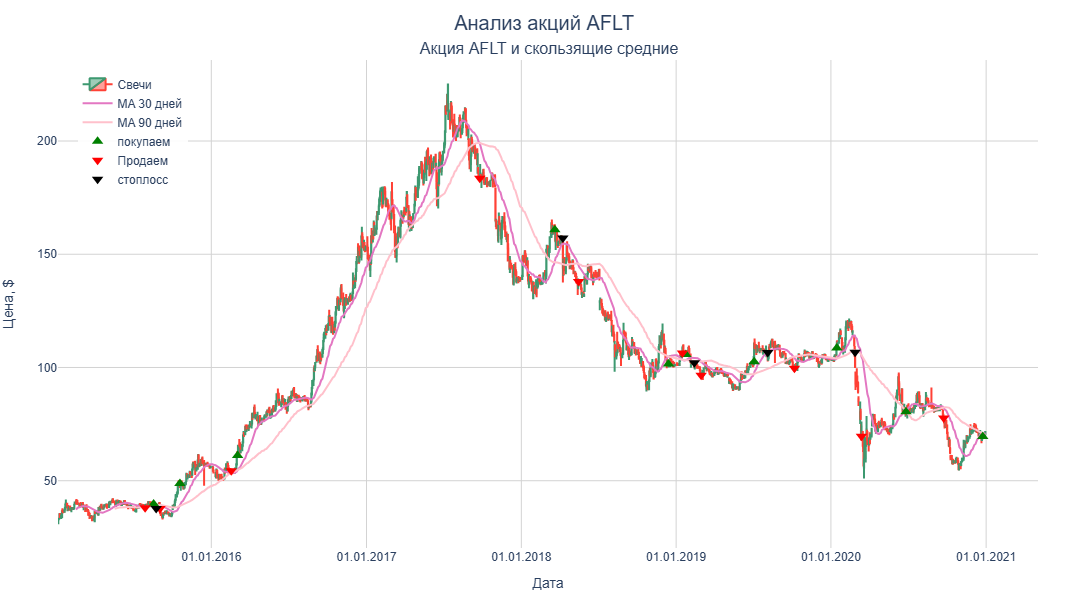

,date,signal,num_shares,share_price,cash,share_value
0,2015-07-29,sig_sale,0,38.12,100000.00,0.00
1,2015-08-18,sig_buy,0,39.72,100000.00,0.00
2,2015-08-19,buy,2500,40.00,0.00,100000.00
3,2015-08-24,stop_loss,2500,37.70,94250.00,94250.00
4,2015-09-02,sig_sale,0,37.77,94250.00,0.00
5,2015-10-19,sig_buy,0,48.80,94250.00,0.00
6,2015-10-20,buy,1951,48.30,16.70,94233.30
7,2016-02-17,sig_sale,1951,54.40,16.70,106134.40
8,2016-02-18,buy,1951,54.30,105956.00,105939.30
9,2016-03-03,sig_buy,0,61.16,105956.00,0.00


In [336]:
answer_df =  trade_bot_moex(tiker = tiker,
               money = money,
               start = start,
               finish = finish,
               stop_loss = stop_loss,
               short_window  = short_window,
               long_window = long_window) # ну вот с аэрофлотом могли бы больше потерять возможно
answer_df